In [1]:
from torch.utils.data import Dataset
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import itertools
import random
from scipy.stats import entropy

In [2]:
class Categorical2d(Dataset):
    """Data generator for samples of p(a,b) from a categorical distribution
    with factorization p(a,b) = p(a)*p(b|a) or p(a,b) = p(b)*p(a|b)."""

    def __init__(self, factorization: str = "a->b", n_categories: int = 10, smoothness = 1, format: str  = "one-hot", rng: npr.Generator = None, seed: int =1234):
        """
        Initialize class
        Args:
            factorization (str): "a->b" for p(a,b) = p(a)*p(b|a); "b->a" for p(a,b) = p(b)*p(a|b); "a,b" for p(a,b) = p(a)*p(b). Effectively, "b->a" is implemented by swapping a and b before returning them.
            n_categories (int): The number of categories the categorical distributions p(a) and p(b) have. They will both have the same number of categories.
            smoothness (float): A factor controlling how smooth the distributions are. 0.1 is very spiky, 1 is intermediate, 5 is somewhat smooth, 20 is very smooth.
            format (str): "digit" to return regular digits e.g. [a, b] = [1, 5], or "one-hot" to return one-hot encoded values.
            rng (numpy.random.Generator): A random number generator for generating data.
            seed (int): Seed to initialize a new rng if none is given.
        """
        self.factorization = factorization
        self.n_categories = n_categories
        self.smoothness = smoothness
        self.format = format

        # Initialize random number generator
        self.rng = rng if rng is not None else npr.default_rng(seed=npr.randint(0,10000))

        self.vec = np.ones(self.n_categories)
        
        # Initialize distributions with Dirichlet priors
        self.p_A = self.rng.dirichlet(alpha = self.smoothness * self.vec)
        
        ## BDeu:
        self.p_BgivenA = self.rng.dirichlet(alpha = self.smoothness * self.vec / self.n_categories, size=self.n_categories)
        
        self.p_B = self.rng.dirichlet(alpha = self.smoothness * self.vec) # This is only used if a and b are independent

    def __len__(self) -> int:
        """
        Length of the dataset. It's dynamically generated, but to avoid infinite loops when
        working with this dataset, let's just set len() to a very large number
        """
        return 1e10
    
    def __getitem__(self, n) -> np.array:
        """
        Sample n samples from p(a,b) and return the data.
        (Note: Typically the argument here is idx and refers to the index of the data point, I've misused this functionality to indicate number of randomly sampled points)
        
        Note that if the factorization is "b->a", the code will proceed as if the factorization was "a->b" and at the end just swaps a and b, without loss of generality.

        Args:
            idx (int): ID of the data item in a set, gets ignored because we sample from distribution
        """
        a = self.rng.choice(self.n_categories, size=(n), p=self.p_A)

        if self.factorization == "a,b":
            # Sample b independently
            b = self.rng.choice(self.n_categories, size=(n), p=self.p_B)
        elif self.factorization in ("a->b", "b->a"):
            # Sample b given a, n times
            b = np.array([self.rng.choice(self.n_categories, p=self.p_BgivenA[a[i]]) for i in range(n)])
        else:
            raise ValueError('Factorization unknown !')

        # Change format of a and b if desired
        a, b = self.__format__(a, b, n)

        if self.factorization in ("a->b", "a,b"):
            return np.array([a,b]).transpose(1,0,2) # Use the transpose to get shape (n, 2, n_categories)
        if self.factorization == "b->a":
            # Swap a and b
            return np.array([b,a]).transpose(1,0,2)

    def __format__(self, a, b, n) -> tuple:
        """
        Format numbers a and b according to self.format
        Returns:
            (a, b): Set of a and b
            n: Number of data points
        """
        if self.format == "digit":
            return a, b
                
        elif self.format == "one-hot":
            a_onehot = np.eye(self.n_categories)[a]
            b_onehot = np.eye(self.n_categories)[b]
            return a_onehot, b_onehot
        
        else:
            raise ValueError('Unknown data format requested!')

    def intervention(self) -> None:
        """
        Perform an intervention in the data generation process by randomly changing the distribution of one independent variable, p(a).
        Note that if factorization is "b->a", then this amounts to changing p(b) since __getitem__ eventually swaps a and b before returning them.
        """
        self.p_A = self.rng.dirichlet(alpha = self.smoothness * self.vec)
        # self.p_BgivenA = self.rng.dirichlet(alpha = self.smoothness * np.ones(self.n_categories)  / self.n_categories, size=self.n_categories)

In [3]:
def show_vec(vec):
    print(np.round(vec, 3))
    plt.imshow(vec[None,], vmin=0, vmax=1, cmap=plt.cm.binary)
    plt.colorbar()

In [4]:
def show_vec_dist(arr):
    k = arr.shape[1]
    range = [0,1]
    n_bins = 1000
    fig, axes = plt.subplots(1,k, figsize=(10,1))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.hist(arr[:,i],bins=100, range=range, density=True,zorder=1)

In [5]:
distributions = []
for i in range(10000):
    distributions += [Categorical2d(n_categories=5, smoothness=1)]

# p(A)

Show one p(A) as an example:

[0.066 0.338 0.046 0.064 0.486]


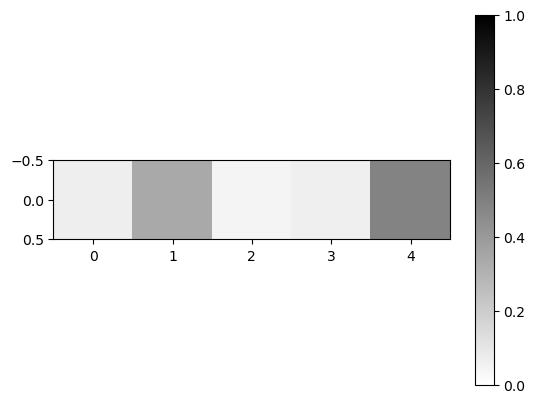

In [6]:
p_As = np.array([dist.p_A for dist in distributions])
show_vec(p_As[npr.randint(1,10000)])

Show the distribution of values for each probability in the vector above across 10k sampled distributions:

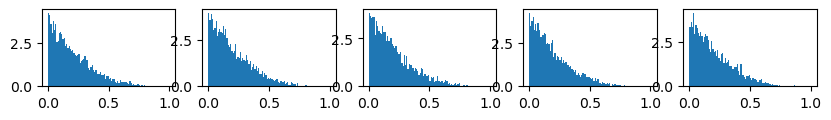

In [7]:
show_vec_dist(p_As)

In [8]:
np.mean(entropy(p_As, axis=1))

1.2879993553203835

# p(B)

Show the distribution of values for each probability in the vector above across 10k sampled distributions:

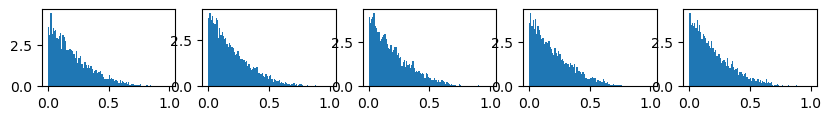

In [9]:
p_Bs = np.array([dist.p_A @ dist.p_BgivenA for dist in distributions])
show_vec_dist(p_Bs)

Show one p(B) as an example:

[0.23  0.047 0.035 0.071 0.618]


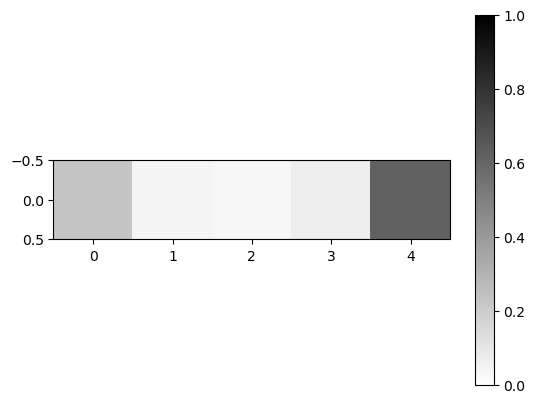

In [10]:
show_vec(p_Bs[npr.randint(1,10000)])

In [11]:
np.mean(entropy(p_Bs, axis=1))

1.2860431719713192

# p(B|A)

Look at one matrix as an example:

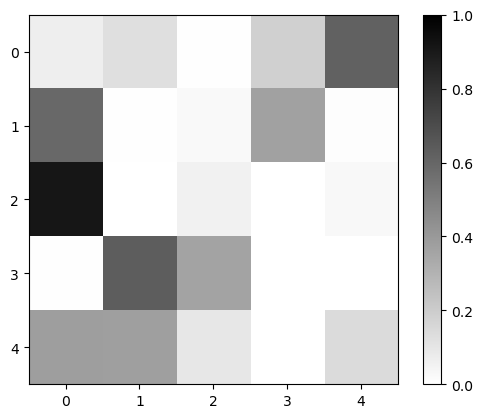

In [12]:
p_BgivenAs = np.array([dist.p_BgivenA for dist in distributions])
plt.imshow(p_BgivenAs[0], vmin=0, vmax=1, cmap = plt.cm.binary)
plt.colorbar()

Look at distributions for values in the different rows:

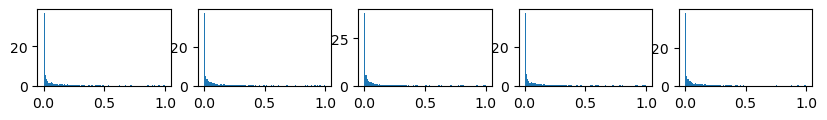

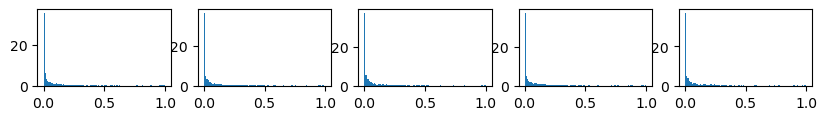

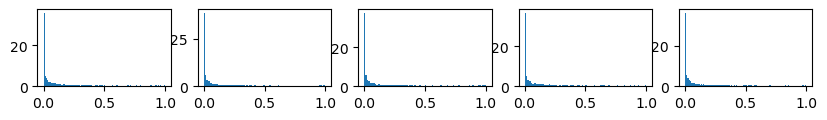

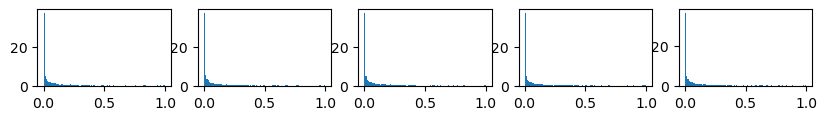

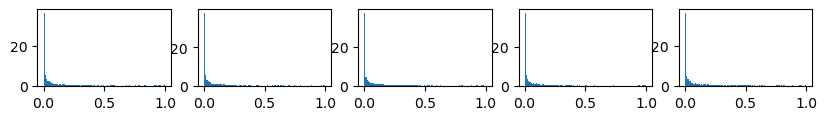

In [13]:
for r in range(p_BgivenAs.shape[1]):
    show_vec_dist(p_BgivenAs[:,r,:])

# p(A|B)

Look at one matrix as an example:

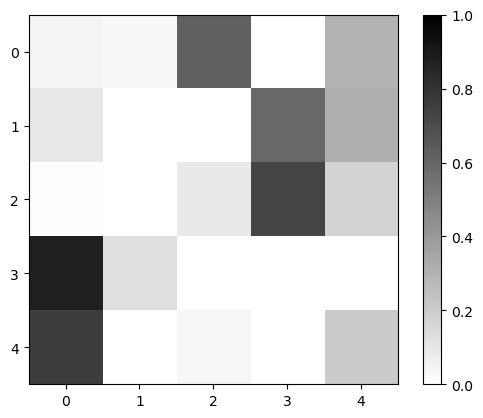

In [14]:
p_AgivenBs = np.array([1 / (dist.p_A @ dist.p_BgivenA)[:, None] * dist.p_A * dist.p_BgivenA.T for dist in distributions])
plt.imshow(p_AgivenBs[0], vmin=0, vmax=1, cmap = plt.cm.binary)
plt.colorbar()

Look at distributions for values in the different rows:

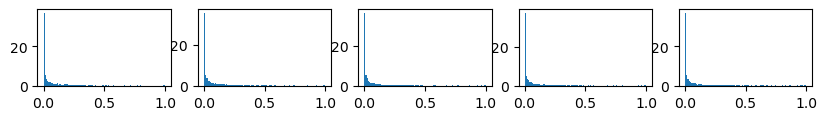

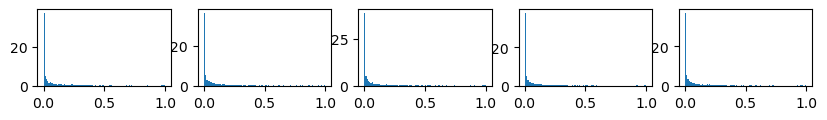

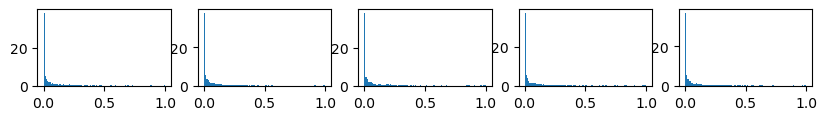

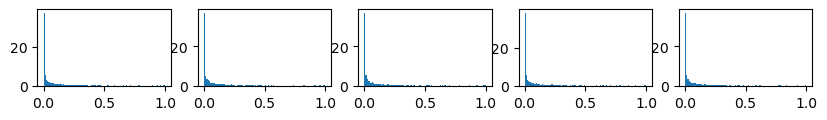

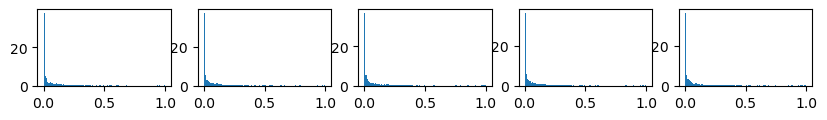

In [15]:
for r in range(p_AgivenBs.shape[1]):
    show_vec_dist(p_AgivenBs[:,r,:])